In [1]:
# import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa

In [2]:
# GPIB/LAN addresses of instruments
rm = pyvisa.ResourceManager()
print(rm.list_resources()) # list connected instruments

keithley = rm.open_resource('GPIB1::18::INSTR')
print(keithley.query('*IDN?')) # check connection to Keithley SMU
keithley.write('*WAI') # wait until finished
keithley.timeout = 120000 # set timeout to 120 seconds

('TCPIP0::192.168.0.5::inst0::INSTR', 'GPIB0::10::INSTR', 'GPIB1::18::INSTR')
KEITHLEY INSTRUMENTS,MODEL 2450,04475568,1.6.7c



In [6]:
# Measurement settings for SMU
keithley.write('*RST') # Restore Series 2450 defaults.
keithley.write('*LANG SCPI')
keithley.write('ROUT:TERM REAR')# Set instrument to use REAR panel (important for low current measuerement)
keithley.write('SENS:FUNC CURR')#Select measure current function.
keithley.write('SENS:CURR:RANG:AUTO ON')#Auto range for current measurement ON
keithley.write('SOUR:FUNC VOLT')#Select source voltage function.
keithley.write('SOUR:VOLT:RANG 10') #Set compliance for voltage (V)
keithley.write('SOUR:VOLT:ILIM 0.05') ##Set compliance for current (A)
# dc voltage steps
v_start = 0
v_stop = 10
num = 201
delay = 0.5

keithley.write('SOUR:SWE:VOLT:LIN '+v_start+', '+v_stop+', '+num+', '+delay+' ')#Linear sweep
#keithley.write('SOUR:SWE:VOLT:LIN 0, 10, 201, 0.5')
keithley.write('INIT')
keithley.write('*WAI')
# Save the measured data in variables
current = keithley.query_ascii_values('TRAC:DATA? 1, '+str(num)+', "defbuffer1", READ')
voltage = keithley.query_ascii_values('TRAC:DATA? 1, '+str(num)+', "defbuffer1", SOUR')

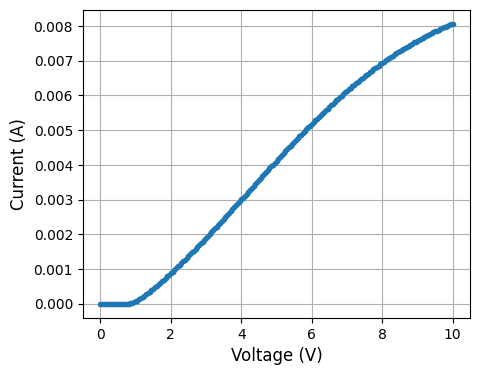

In [7]:
# plot the figure using data variables
plt.figure(figsize=(5,4))
plt.xlabel('Voltage (V)', fontsize = 12)
plt.ylabel('Current (A)', fontsize = 12)
plt.plot(voltage,current,'.-')
plt.grid()
plt.show()

In [8]:
# create a dataframe using data variables and save the data for future use
I_V_curve = pd.DataFrame(
    {
        "Voltage (V)"         : voltage,
        "Current (A)"         : current,
    }
)

filename = 'IV_wafer02_middleblock_device01L'
I_V_curve.to_csv(filename + '.csv', index=False)


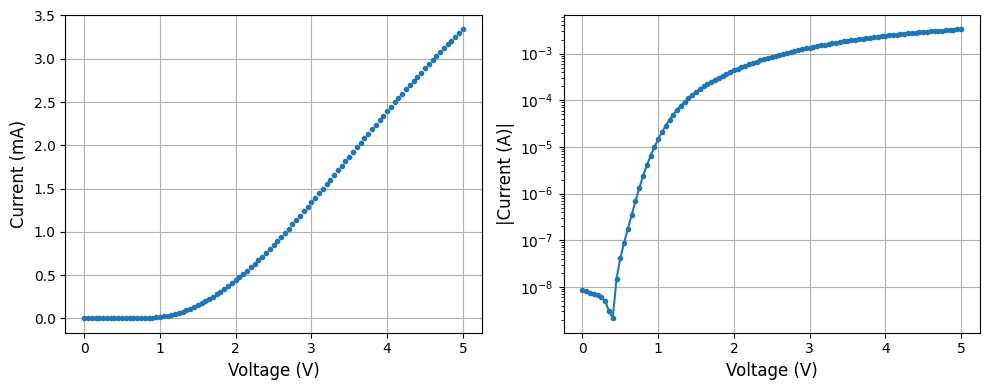

In [54]:
# read the saved files and re-use the data to plot
data = pd.read_csv(filename + '.csv', delimiter=';')
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout = 'tight')

axs[0].set_xlabel('Voltage (V)', fontsize=12)
axs[0].set_ylabel('Current (mA)', fontsize=12)
axs[0].set_xticks(np.arange(-5, 6, 1), minor=True)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].plot(data['Voltage (V)'], data['Current (A)']*1e3, '.')
axs[0].grid()

axs[1].set_xlabel('Voltage (V)', fontsize=12)
axs[1].set_ylabel('|Current (A)|', fontsize=12) 
xticks = np.arange(-5, 6, 1)
axs[1].set_xticks(xticks, minor=True)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_yscale("log")  
axs[1].plot(data['Voltage (V)'], abs(data['Current (A)']), marker='.')
axs[1].grid()

#plt.savefig(filename + '.jpg', dpi = 300)

In [ ]:
# Fit the data and estimate the resistance of the device
data = pd.read_csv("IV_wafer02_rightblock_device01R.csv", delimiter=';')
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout = 'tight')

axs[0].set_xlabel('Voltage (V)', fontsize=12)
axs[0].set_ylabel('Current (mA)', fontsize=12)
axs[0].set_xticks(np.arange(-5, 6, 1), minor=True)
axs[0].tick_params(axis='both', which='major', labelsize=10)

m,c = np.polyfit(data['Voltage (V)'][20:40], data['Current (A)'][20:40]*1e3, 1)
axs[0].plot(data['Voltage (V)'], data['Current (A)']*1e3, '.', 
            data['Voltage (V)'][20:40], data['Voltage (V)'][20:40]*m + c, '--k')
axs[0].grid()
axs[0].text(3, 1, '$R_{s}$ = ' + str(round(1000/m)) +' \u03A9')

axs[1].set_xlabel('Voltage (V)', fontsize=12)
axs[1].set_ylabel('|Current (A)|', fontsize=12) 
xticks = np.arange(-5, 6, 1)
axs[1].set_xticks(xticks, minor=True)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_yscale("log")  
axs[1].plot(data['Voltage (V)'], abs(data['Current (A)']), marker='.')
axs[1].grid()

#figurename = input("Save figure as :")
#plt.savefig(figurename + '.jpg', dpi = 300)

In [ ]:
# Plot data from multiple files in a figure

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout = 'tight')
axs[0].set_xlabel('Voltage (V)', fontsize=12)
axs[0].set_ylabel('Current (mA)', fontsize=12)
axs[0].set_xticks(np.arange(0, 10, 1), minor=True)
axs[0].tick_params(axis='both', which='major', labelsize=10)

csv_files = glob.glob("*.csv")
n = 6
colors = plt.cm.viridis(np.linspace(0, 1, n)) # using color map for plot
i=0
for file in csv_files:
    data = pd.read_csv(file, delimiter=';')
    axs[0].plot(data['Voltage (V)'], data['Current (A)']*1e3, '-', color=colors[i])
    i += 1
axs[0].grid()

axs[1].set_xlabel('Voltage (V)', fontsize=12)
axs[1].set_ylabel('Current (A)', fontsize=12) 
axs[1].set_xticks(np.arange(0, 10, 1), minor=True)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_yscale("log")
#axs[1].set_yticks(minor=True)
n = 6
colors = plt.cm.viridis(np.linspace(0, 1, n)) # using color map for plot
i=0
for file in csv_files:
    data = pd.read_csv(file, delimiter=';')
    axs[1].plot(data['Voltage (V)'], (data['Current (A)']), '-', color=colors[i])
    i += 1
axs[1].grid()

#figurename = input("Save figure as :")
#plt.savefig('combined_IV_10V.jpg', dpi = 300)